Here we will look at some aggregations over specific start and stop locations. Going from point A to point B is a 'trip'.

Grouping statistics by trip cancut the data size by a large amount, as the number of trips:
${n \choose 2}^2 $ (choosing pickups and dropoffs). 

In [1]:
from Fair_Fare.feature_utils import load_hdf
from Fair_Fare.aggregations import agg_on_trips
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
sns.set()

import xgboost as xgb

from joblib import dump, load
from sklearn.linear_model import LinearRegression

#taxi_linmod = load('taxi_lin_model.joblib')
taxi_treemod = xgb.Booster()
taxi_treemod.load_model("taxi_xgb_full")

#tnp_linmod = load('tnp_lin_model.joblib')
tnp_treemod = xgb.Booster()
tnp_treemod.load_model("tnp_xgb_full")


data = {"path":"data/","taxi":"taxi_test.h5", "rideshare":"tnp_test.h5" }

In [2]:
X = load_hdf(data["path"]+data["rideshare"],100)
y = X["Final_Fare"]
X.drop(["Final_Fare"], axis = 1, inplace = True)
dtest = xgb.DMatrix(X.values)

model_preds = tnp_treemod.predict(dtest)
model_preds.size

3047211

In [3]:
rideshare = load_hdf(data["path"]+data["rideshare"]%autoreload 2,100)
rideshare.head()

,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Shared_Trip_Authorized,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,vel_mph,Final_Fare,l2_dist_km,x_dist_km,y_dist_km,bearing,bAirport,day_of_wk,hour
6283605,1913.0,6.7,77.0,22.0,False,41.985472,-87.653794,41.929330,-87.711974,12.608468,17.50,7.881464,4.808806,6.242793,-142.361378,False,5,0
10327851,1335.0,5.4,7.0,32.0,False,41.929078,-87.646293,41.880994,-87.632746,14.561798,15.00,5.462890,1.120689,5.346614,168.152913,False,1,8
581229,1560.0,5.3,6.0,28.0,False,41.934540,-87.643023,41.878667,-87.671654,12.230769,10.67,6.649193,2.368313,6.212725,-159.115063,False,6,14
10148217,590.0,5.9,44.0,68.0,False,41.740206,-87.615970,41.777196,-87.642498,36.000000,12.50,4.664751,2.201044,4.113162,-28.136520,False,1,22
1776825,1126.0,4.8,6.0,4.0,True,41.944227,-87.655998,41.975171,-87.687516,15.346359,5.00,4.316367,2.606686,3.440859,-37.129196,False,3,15


In [16]:
%load_ext autoreload
%autoreload 2
agg = agg_on_trips(rideshare)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


So there are about 900 unique lat/longs giving ~ 500k trip combinations.

#### Grouping by rides:

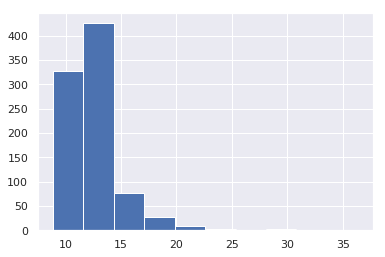

In [83]:
agg.df.groupby(["Pickup_Centroid_Latitude","Pickup_Centroid_Longitude"]).Final_Fare.mean().hist()


In [84]:
# total unique trips with binning above
print(agg.total_unique_paths)

16589


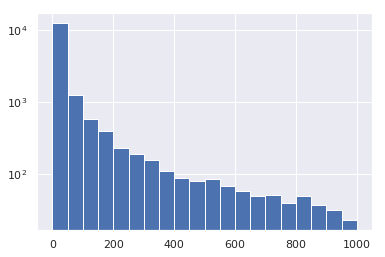

In [85]:
agg.df.groupby('path').Final_Fare.count().hist(bins = 20, range = (0,1000),log = True)

Prints the number of unique trips at this binsize
150k is about the max for the tnp_test data, we know the max possible based on the input data binning
s 400k. We need some balance of bin size between having enough data to show the user a histogram and accuracy.

issue: trip miles has somewhat significant deviation from each other even with fine binning... shared rides?

TODO: Create a function to plot the route on a map and show this histogram at the same time. Intermediate data product is a histogram for each of these routes.

In [89]:
# let's just say a trip is a single row of the dataframe
def single_pt_estimate(trip):
    X = trip
    t = xgb.DMatrix(X.reshape(1,-1))
    return tnp_treemod.predict(t)

#start, end are lat/long pairs
def ride_summary(df,path, hour = 0):#start,end):
    #trip = find_bin(start,end)
    all_rides = df[df.path == path]
    trip = all_rides.iloc[0]
    trip['hour'] = hour
    estimate = single_pt_estimate(trip)
    return estimate
    
    


We want a function that takes a single ride as input,
outputs the histogram and the prediction.

In [200]:
class Stop(object):
    """Small class to keep track of lat/long and geocode of a point on a map."""
    def __init__(self, location):
        self.bGeocoded= False
        self.bAirport = None
        
        if isinstance(location, tuple):
            self.lat = location[0]
            self.long = location[1]
            self.geocode = location
        elif isinstance(location, str):
            self.lat = None
            self.long = None
            self.geocode = location
        else:
            raise ValueError("Stop must be a string or a (lat,long) tuple.")
            
    def __repr__(self):
        if self.bGeocoded:
            return(f"Geocoded Location: {self.geocode}, Coordinates: {(self.lat,self.long)}")
        else:
            return(f"Coordinates: {(self.lat,self.long)}")
            
    
    # TODO: use properties and setters instead of just updating internl vars
    def update_params(self, lat,long,geocode):
        self.lat = lat
        self.long = long
        self.geocode = geocode
        self.bGeocoded= True
        
    
    def bAirport(self,thresh_km = 1):
        midway = (41.7868, -87.7522)
        ohare = (41.9742, -87.9073)
        airport_flag = haversine_dist(self.lat, self.long,
                       midway[0],
                       midway[1]) < thresh_km
        airport_flag |= haversine_dist(self.lat, self.long,
                       ohare[0],
                       ohare[1]) < thresh_km
        self.bAirport = airport_flag
        
        


class Ride(object):
    def __init__(self, start, end,time = datetime.now()):
        self.start = Stop(start)
        self.end = Stop(end)
        self.time = time
        self.path = [self.start,self.end]
        self.as_row = {}
        self.gm = None
        
        self.build_row()
        
    def __repr__(self):
        return f"Start: {self.start} \nEnd: {self.end} \nDetails: {self.as_row}"
        
    ### TODO: Add some protection to the gmaps call
    ### we let gmaps update the lat and long, it should put things on a street if not already
    def gmaps_call(self):
        self.gm = gmaps_handler(self.start.geocode,self.end.geocode, self.time)
        self.start.update_params(self.gm['start_latlong'][0],self.gm['start_latlong'][1],self.gm['start_geocoded'])
        self.end.update_params(self.gm['end_latlong'][0],self.gm['end_latlong'][1],self.gm['end_geocoded'])
   
    def build_row(self):
        if not self.gm:
            self.gmaps_call()
        self.as_row['Trip_Seconds'] = self.gm['time_s']
        self.as_row['Trip_Miles'] = self.gm['dist_m']/1609.34
        self.as_row['Pickup_Centroid_Latitude'] = self.gm['start_latlong'][0]
        self.as_row['Pickup_Centroid_Longitude'] = self.gm['start_latlong'][1]
        self.as_row['Pickup_Dropoff_Latitude'] = self.gm['end_latlong'][0]
        self.as_row['Pickup_Dropoff_Longitude'] = self.gm['end_latlong'][1]
        self.add_airport()
        self.add_time()
   
    def add_airport(self):
        if self.start.bAirport or self.end.bAirport:
            self.as_row['bAirport'] = True
        else:
            self.as_row['bAirport'] = False
    
    def add_time(self):
        self.as_row['hour'] = self.time.hour
        self.as_row['day_of_wk'] = self.time.weekday()
        
    
        

In [201]:
ride = Ride('nyc','dallas')

In [203]:
ride

Start: Geocoded Location: New York, NY, USA, Coordinates: (40.7124773, -74.0062007) 
End: Geocoded Location: Dallas, TX, USA, Coordinates: (32.7759428, -96.7967532) 
Details: {'Trip_Seconds': 85077, 'Trip_Miles': 1547.4119825518537, 'Pickup_Centroid_Latitude': 40.7124773, 'Pickup_Centroid_Longitude': -74.0062007, 'Pickup_Dropoff_Latitude': 32.7759428, 'Pickup_Dropoff_Longitude': -96.7967532, 'bAirport': False, 'hour': 14, 'day_of_wk': 0}

In [122]:
'Trip_Seconds', 'Trip_Miles', 'Shared_Trip_Authorized',
'Pickup_Centroid_Latitude', 'Pickup_Centroid_Longitude',
'Dropoff_Centroid_Latitude', 'Dropoff_Centroid_Longitude', 'vel_mph',
'bAirport', 'day_of_wk', 'hour'

{'start_geocoded': '483 George St, Sydney NSW 2000, Australia',
 'end_geocoded': 'Parramatta NSW 2150, Australia',
 'start_latlong': (-33.8727509, 151.2060594),
 'end_latlong': (-33.8135515, 151.0034258),
 'time_s': 1848,
 'dist_m': 23347}

In [170]:

from Fair_Fare.feature_utils import haversine_dist

def bAirport(stop,thresh_km = 1):
    midway = (41.7868, -87.7522)
    ohare = (41.9742, -87.9073)
    airport_flag = haversine_dist(stop[0], stop[1],
                   midway[0],
                   midway[1]) < thresh_km
    airport_flag |= haversine_dist(stop[0], stop[1],
                   ohare[0],
                   ohare[1]) < thresh_km
    return airport_flag

In [169]:
bAirport((42.7868, -87.7522))

False

In [121]:
### this goes in an API.py file

import googlemaps
from datetime import datetime
import json

def gmaps_handler(start, end, time):
    with open("secrets.json.nogit") as fh:
        secrets = json.loads(fh.read())

    gmaps_client = googlemaps.Client(key=secrets['gmaps_api_key'])
    
    GMAPS_NAME_MAPPING = {'start_address':'start_geocoded',
                      'end_address':'end_geocoded',
                      'start_location':'start_latlong',
                      'end_location':'end_latlong',
                      'duration_in_traffic':'time_s',
                      'distance':'dist_m'}
    
    directions_result = gmaps_client.directions(start,end, departure_time = time)

    dr = directions_result[0]['legs'][0]
    out = {}
    for gname,newname in GMAPS_NAME_MAPPING.items():
        vals = dr[gname]
        if gname == 'start_address' or gname == 'end_address':
            out[newname] = vals
        elif gname == 'end_location' or gname =='start_location':
            out[newname] = tuple([float(val) for val in vals.values()])
        else:
            out[newname] = int(list(vals.values())[1])
    return out
        